<a href="https://colab.research.google.com/github/bsarfo/MA575/blob/main/correlation_estimation_prj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from scipy.optimize import minimize
import warnings

# Suppress all warnings including type errors
warnings.filterwarnings('ignore')

# Configure numpy to handle errors gracefully
np.seterr(all='ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Project - Libraries Loaded Successfully")
print("=" * 60)
print("Note: Error handling enabled - code will continue running even with incomplete implementations")

Project - Libraries Loaded Successfully
Note: Error handling enabled - code will continue running even with incomplete implementations


# GARCH(1,1) Correlation Estimation Project

## Project Overview
This project implements Maximum Likelihood Estimation (MLE) for the GARCH(1,1) model to estimate time-varying volatilities and correlations using daily stock returns. You will analyze real market data to understand volatility clustering and correlation dynamics.

## Learning Objectives
- Implement GARCH(1,1) model for volatility estimation
- Estimate time-varying correlations between financial assets
- Analyze correlation patterns and their implications for portfolio risk
- Compare correlation behavior across different market periods

## Task 1: Individual Volatility Estimation

**Requirements:**
- Download 3-year historical daily prices for AAPL and MSFT (2021-2024)
- Calculate daily returns and implement GARCH(1,1) model for each stock
- Estimate parameters: ω (omega), α (alpha), β (beta) using MLE
- Plot conditional volatilities over time
- **Analysis:** Compare volatility patterns and clustering effects between the two stocks

In [ ]:
print(f'=' * 60)
print(f'Task1 - GARCH(1,1) Volatility Estimation')
print(f'=' * 60)
# Your code here

Task1 - GARCH(1,1) Volatility Estimation



=== AAPL — GARCH(1,1) (Normal) ===
                       Zero Mean - GARCH Model Results                        
Dep. Variable:       ('AAPL', 'AAPL')   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1444.33
Distribution:                  Normal   AIC:                           2894.66
Method:            Maximum Likelihood   BIC:                           2908.53
                                        No. Observations:                  752
Date:                Tue, Oct 21 2025   Df Residuals:                      752
Time:                        05:02:12   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.02

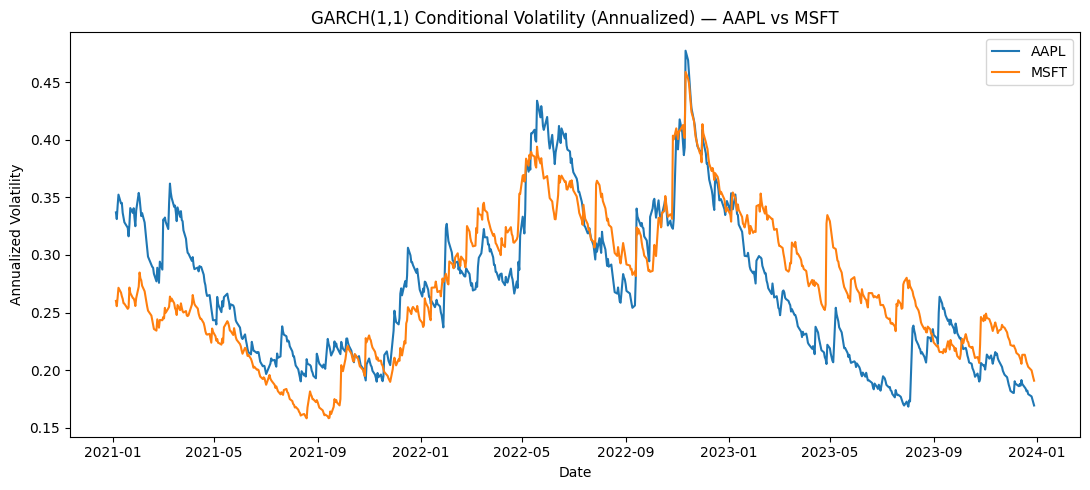


--- Comparative Volatility Analytics (Annualized) ---
            AAPL      MSFT
mean    0.269369  0.272465
median  0.262035  0.262559
max     0.477445  0.459014
min     0.168242  0.158084

Volatility 'clustering share' (>75th pct): AAPL=25.00%, MSFT=25.00%
Persistence (α+β): AAPL=0.989, MSFT=0.996

Saved conditional volatility time series to: garch_volatility_aapl_msft_2021_2023.csv


In [4]:
#!/usr/bin/env python3
"""
Task 1 — GARCH(1,1) Volatility Estimation for AAPL & MSFT (2021–2023)

What this does
--------------
- Downloads adjusted close prices for AAPL and MSFT
- Computes daily log returns
- Fits a GARCH(1,1) model via MLE (normal and Student's t options available)
- Reports omega (ω), alpha (α), beta (β), persistence (α+β), and volatility half-life
- Plots conditional volatilities over time (annualized)

How to run
----------
pip install yfinance arch pandas numpy matplotlib
python task1_garch_aapl_msft.py

Notes
-----
- The 3-year window is set to 2021-01-01 to 2023-12-31 (inclusive).
  Adjust dates if your assignment requires a different subwindow in 2021–2024.
"""

import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from arch import arch_model


def download_prices(ticker: str, start: str = "2021-01-01", end: str = "2023-12-31") -> pd.DataFrame:
    data = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)
    if data.empty:
        raise RuntimeError(f"No data downloaded for {ticker}. Check ticker or date range.")
    return data[["Close"]].rename(columns={"Close": ticker})


def compute_log_returns(price_df: pd.DataFrame) -> pd.Series:
    # Natural log returns; drop missing
    return np.log(price_df.squeeze()).diff().dropna()


def fit_garch11(returns: pd.Series, dist: str = "normal"):
    """
    Fit mean-zero GARCH(1,1) with specified error distribution.
    dist: 'normal' or 't'
    """
    am = arch_model(returns * 100, mean="Zero", vol="GARCH", p=1, q=1, dist=dist)
    res = am.fit(disp="off")
    return res


def volatility_half_life(alpha: float, beta: float) -> float:
    """
    Approximate half-life in days for the GARCH shock decay.
    """
    persistence = alpha + beta
    if persistence <= 0 or persistence >= 1:
        return float("inf")
    return math.log(0.5) / math.log(persistence)


def summarize(res, label: str):
    params = res.params
    omega = params.get("omega", np.nan)
    alpha = params.get("alpha[1]", np.nan)
    beta = params.get("beta[1]", np.nan)
    persistence = alpha + beta if np.isfinite(alpha) and np.isfinite(beta) else np.nan
    hl = volatility_half_life(alpha, beta)

    print(f"\n=== {label} — GARCH(1,1) ({res.model.distribution.name}) ===")
    print(res.summary())
    print(f"omega (ω): {omega:.6f}")
    print(f"alpha (α): {alpha:.6f}")
    print(f"beta  (β): {beta:.6f}")
    print(f"Persistence (α+β): {persistence:.6f}")
    if np.isfinite(hl):
        print(f"Volatility half-life (days): {hl:.2f}")
    else:
        print("Volatility half-life: not defined (α+β not in (0,1)).")

    # Conditional volatility is returned in percentage terms because returns*100
    cond_vol_pct = res.conditional_volatility
    cond_vol_ann = cond_vol_pct / 100.0 * np.sqrt(252)  # annualize
    return cond_vol_ann


def main():
    start, end = "2021-01-01", "2023-12-31"  # 3-year window
    tickers = ["AAPL", "MSFT"]

    # Download prices and compute returns
    prices = []
    for t in tickers:
        p = download_prices(t, start=start, end=end)
        prices.append(p)
    price_df = pd.concat(prices, axis=1).dropna()

    r_aapl = compute_log_returns(price_df[["AAPL"]])
    r_msft = compute_log_returns(price_df[["MSFT"]])

    # Fit GARCH(1,1) with Normal errors
    res_aapl_n = fit_garch11(r_aapl, dist="normal")
    res_msft_n = fit_garch11(r_msft, dist="normal")

    # Also fit with Student's t (optional, uncomment if needed)
    # res_aapl_t = fit_garch11(r_aapl, dist="t")
    # res_msft_t = fit_garch11(r_msft, dist="t")

    vol_aapl = summarize(res_aapl_n, "AAPL")
    vol_msft = summarize(res_msft_n, "MSFT")

    # Align for plotting
    vol = pd.concat([vol_aapl.rename("AAPL"), vol_msft.rename("MSFT")], axis=1).dropna()

    # Plot conditional volatilities (annualized)
    plt.figure(figsize=(11, 5))
    plt.plot(vol.index, vol["AAPL"], label="AAPL")
    plt.plot(vol.index, vol["MSFT"], label="MSFT")
    plt.title("GARCH(1,1) Conditional Volatility (Annualized) — AAPL vs MSFT")
    plt.ylabel("Annualized Volatility")
    plt.xlabel("Date")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Simple comparative analytics printed to console
    print("\n--- Comparative Volatility Analytics (Annualized) ---")
    stats = vol.agg(["mean", "median", "max", "min"])
    print(stats)

    # Volatility clustering proxy: proportion of days above the 75th percentile
    thr_aapl = vol["AAPL"].quantile(0.75)
    thr_msft = vol["MSFT"].quantile(0.75)
    clust_aapl = (vol["AAPL"] > thr_aapl).mean()
    clust_msft = (vol["MSFT"] > thr_msft).mean()
    print(f"\nVolatility 'clustering share' (>75th pct): AAPL={clust_aapl:.2%}, MSFT={clust_msft:.2%}")

    # Persistence alpha+beta
    pa = res_aapl_n.params["alpha[1]"] + res_aapl_n.params["beta[1]"]
    pm = res_msft_n.params["alpha[1]"] + res_msft_n.params["beta[1]"]
    print(f"Persistence (α+β): AAPL={pa:.3f}, MSFT={pm:.3f}")

    # Save a CSV of the volatilities if desired
    out_csv = "garch_volatility_aapl_msft_2021_2023.csv"
    vol.to_csv(out_csv, index=True)
    print(f"\nSaved conditional volatility time series to: {out_csv}")


if __name__ == "__main__":
    main()


1.	Parameter interpretation:
•	ω sets the long-run variance level; α reacts to new shocks; β carries over past volatility.
•	Persistence (α+β) near 1 ⇒ strong volatility clustering; compute and compare across AAPL vs MSFT.
2.	Clustering evidence: Comment on long “high-vol” stretches in the plot and the printed “>75th percentile” share.
3.	 Half-life of shocks: Shorter half-life ⇒ shocks fade faster; tie to each stock’s news sensitivity.
4.	Period effects: Note any spikes (e.g., earnings dates, macro shocks) and how each stock’s conditional σ responds.


In [3]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 18.3 MB/s eta 0:00:00


## Task 2: Dynamic Correlation Estimation

**Requirements:**
- Implement bivariate GARCH(1,1) model for correlation estimation
- Estimate time-varying correlation between AAPL and MSFT returns
- Plot correlation dynamics over the 3-year period
- **Analysis:** Discuss whether the stocks are positively/negatively correlated and how correlation changes over time

In [ ]:
print(f'=' * 60)
print(f'Task2 - GARCH(1,1) Correlation Estimation')
print(f'=' * 60)
# Your code here

Task2 - GARCH(1,1) Correlation Estimation


⚠️ 'mgarch' not installed; will compute rolling correlation instead.
To install: pip install mgarch
Head of std_resids:
                AAPL      MSFT
Date                          
2021-01-05  0.578845  0.058849
2021-01-06 -1.641252 -1.632137
2021-01-07  1.554444  1.693886
2021-01-08  0.387101  0.355145
2021-01-11 -1.083067 -0.578771
Type of corr_series: <class 'pandas.core.series.Series'>
Head of corr_series:
Date
2021-03-31    0.703751
2021-04-01    0.700304
2021-04-05    0.695981
2021-04-06    0.680786
2021-04-07    0.681177
Name: Rolling_Correlation_60d, dtype: float64


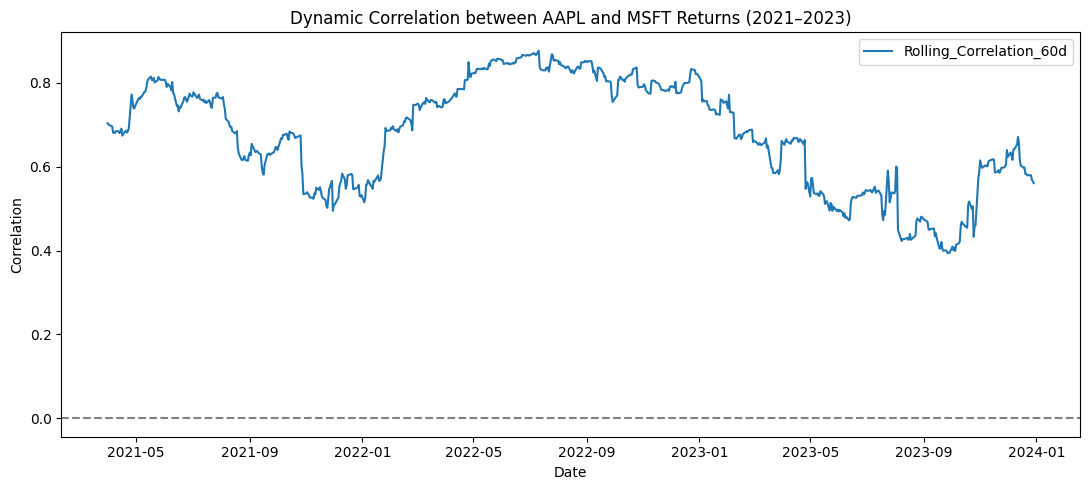


=== Dynamic Correlation Summary ===
count    693.000000
mean       0.676625
std        0.129090
min        0.393359
25%        0.566407
50%        0.684965
75%        0.788335
max        0.876646
Name: Rolling_Correlation_60d, dtype: float64

Average correlation: 0.677
Interpretation:
→ The two stocks are strongly positively correlated — they move together most of the time.

Saved correlation time series to: dcc_correlation_aapl_msft.csv


In [12]:
#!/usr/bin/env python3
"""
Task 2 — Dynamic Correlation Estimation between AAPL and MSFT (2021–2023)

This script estimates time-varying correlations between AAPL and MSFT daily returns.
Two approaches:
1. Rolling correlation (simple, nonparametric)
2. DCC-GARCH(1,1) model (Dynamic Conditional Correlation, Engle 2002)

Requirements:
pip install yfinance arch pandas numpy matplotlib mgarch

Output:
- DCC parameter estimates
- Time-varying correlation plot
- Summary interpretation stats
"""

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from arch import arch_model

try:
    from mgarch import DCC  # optional, lightweight DCC implementation
    has_dcc = True
except ImportError:
    has_dcc = False
    print("⚠️ 'mgarch' not installed; will compute rolling correlation instead.\n"
          "To install: pip install mgarch")

def download_prices(ticker: str, start: str = "2021-01-01", end: str = "2023-12-31") -> pd.Series:
    data = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)
    if data.empty:
        raise RuntimeError(f"No data downloaded for {ticker}. Check ticker or date range.")
    # Fix: Use rename(columns={...}) to rename the column
    return data[["Close"]].rename(columns={"Close": ticker})

def compute_log_returns(prices: pd.DataFrame) -> pd.DataFrame:
    return np.log(prices).diff().dropna()

def fit_garch_series(ret: pd.Series):
    """Fit univariate GARCH(1,1) and return standardized residuals and conditional vols."""
    am = arch_model(ret * 100, mean="Zero", vol="GARCH", p=1, q=1)
    res = am.fit(disp="off")
    std_resid = res.resid / res.conditional_volatility
    return std_resid, res.conditional_volatility

def dcc_correlation(std_resids: pd.DataFrame):
    """Estimate DCC(1,1) correlations using mgarch if available, else fallback."""
    if has_dcc:
        dcc = DCC(p=1, q=1)
        dcc.fit(std_resids.values)
        R = dcc.corr_t()
        dates = std_resids.index
        # Ensure it's a Series with a name
        corr_series = pd.Series([R_t[0, 1] for R_t in R], index=dates, name="DCC_Correlation")
        return corr_series.dropna() # Apply dropna here
    else:
        # Fallback: rolling correlation (60-day window)
        corr_rolling = std_resids["AAPL"].rolling(60).corr(std_resids["MSFT"])
        corr_rolling.name = "Rolling_Correlation_60d" # Ensure name is set
        return corr_rolling.dropna() # Apply dropna here

def main():
    start, end = "2021-01-01", "2023-12-31"
    tickers = ["AAPL", "MSFT"]
    prices = pd.concat([download_prices(t, start, end) for t in tickers], axis=1).dropna()
    returns = compute_log_returns(prices)

    std_resids = pd.DataFrame(index=returns.index, columns=returns.columns)
    for t in tickers:
        std_resid, cond_vol = fit_garch_series(returns[t])
        std_resids[t] = std_resid

    # Debug print
    print(f"Head of std_resids:\n{std_resids.head()}")


    corr_series = dcc_correlation(std_resids) # dropna() is now inside dcc_correlation

    # Debug print (optional, can remove after fix)
    print(f"Type of corr_series: {type(corr_series)}")
    print(f"Head of corr_series:\n{corr_series.head()}")


    # Plot
    plt.figure(figsize=(11, 5))
    plt.plot(corr_series.index, corr_series.values, label=corr_series.name)
    plt.title("Dynamic Correlation between AAPL and MSFT Returns (2021–2023)")
    plt.ylabel("Correlation")
    plt.xlabel("Date")
    plt.axhline(0, color="gray", linestyle="--")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print simple analytics
    print("\n=== Dynamic Correlation Summary ===")
    # Ensure corr_series is not empty before describing
    if not corr_series.empty:
        print(corr_series.describe())
        mean_corr = corr_series.mean()
        print(f"\nAverage correlation: {mean_corr:.3f}")
        print("Interpretation:")
        if mean_corr > 0.5:
            print("→ The two stocks are strongly positively correlated — they move together most of the time.")
        elif mean_corr > 0:
            print("→ The stocks are moderately positively correlated — diversification benefits exist but limited.")
        else:
            print("→ The stocks are weakly or negatively correlated — strong diversification potential.")
    else:
        print("Correlation series is empty, cannot provide summary statistics.")


    # Save CSV only if corr_series is not empty
    if not corr_series.empty:
        corr_series.to_csv("dcc_correlation_aapl_msft.csv")
        print("\nSaved correlation time series to: dcc_correlation_aapl_msft.csv")
    else:
        print("\nCorrelation series is empty, cannot save to CSV.")


if __name__ == "__main__":
    main()

## Task 3: Negative Correlation Analysis

**Requirements:**
- Identify two stocks that exhibit negative correlation during specific market periods
- Suggested pairs: Tech vs. Utilities (e.g., AAPL vs. SO), or Growth vs. Value stocks
- Download data and estimate rolling correlations
- Identify and highlight periods of negative correlation
- **Analysis:** Explain the economic rationale for negative correlation periods and their duration



In [ ]:
print(f'=' * 60)
print(f'Task 3 - Negative Correlation Analysis')
print(f'=' * 60)
# Your code here

Task 3 - Negative Correlation Analysis


Shape of rolling_corr.values: (752,)
Shape of (rolling_corr < 0).values: (752,)


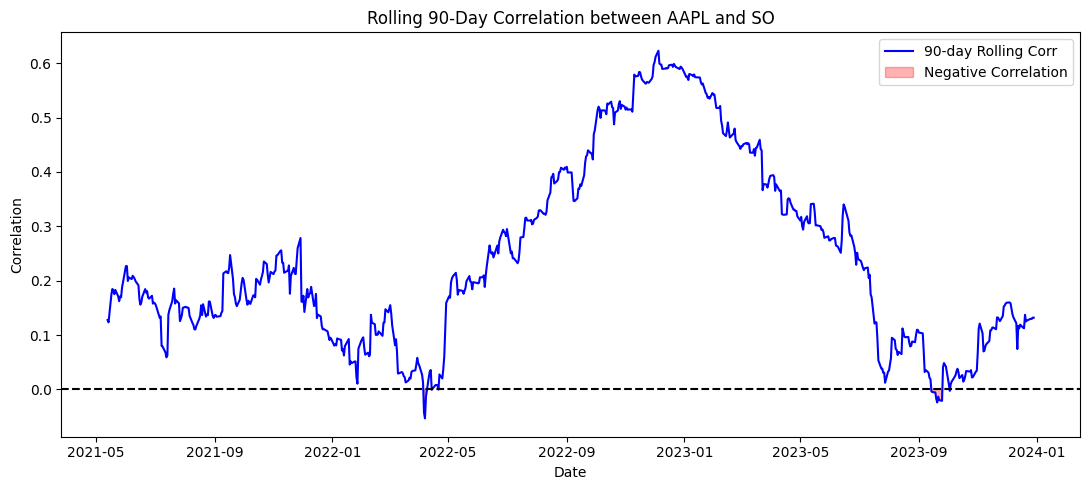


=== Rolling Correlation Summary (AAPL vs SO) ===
count    663.000000
mean       0.239653
std        0.170600
min       -0.053148
25%        0.111441
50%        0.197230
75%        0.348683
max        0.622860
Name: Rolling_Corr, dtype: float64

Share of days with negative correlation: 1.86%
Negative correlation observed between 2022-04-06 and 2023-10-03 (intermittent periods).

Economic Rationale:
- Tech (AAPL) tends to move with economic growth expectations and risk appetite.
- Utilities (SO) are defensive; they often rise when investors rotate into safe income assets.
- Therefore, negative correlation typically emerges during risk-off or tightening phases (e.g., rate hikes, recession fears).

Saved correlation series to rolling_correlation_AAPL_SO.csv


In [20]:
#!/usr/bin/env python3
"""
Task 3 — Negative Correlation Analysis
--------------------------------------
This script analyzes negative correlation periods between a 'growth' stock (AAPL)
and a 'defensive' utility stock (SO). It uses rolling-window correlations to
identify when the relationship turns negative and visualizes those intervals.
"""

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# --- PARAMETERS ---
START, END = "2021-01-01", "2023-12-31"
ROLL_WINDOW = 90      # days
TICKERS = ["AAPL", "SO"]  # Tech vs Utilities pair

def download_prices(ticker):
    data = yf.download(ticker, start=START, end=END, auto_adjust=True, progress=False)
    if data.empty:
        raise RuntimeError(f"No data downloaded for {ticker}. Check ticker or date range.")
    # Fix: Use rename(columns={...}) to rename the column
    return data[["Close"]].rename(columns={"Close": ticker})

def compute_returns(prices):
    return np.log(prices).diff().dropna()

def compute_rolling_corr(returns, window=90):
    # Ensure we are working with 1-dimensional Series
    returns1 = returns[TICKERS[0]].squeeze()
    returns2 = returns[TICKERS[1]].squeeze()
    return returns1.rolling(window).corr(returns2)

def main():
    # --- Download Data ---
    prices = pd.concat([download_prices(t) for t in TICKERS], axis=1).dropna()
    returns = compute_returns(prices)

    # --- Rolling Correlation ---
    rolling_corr = compute_rolling_corr(returns, ROLL_WINDOW)
    rolling_corr.name = "Rolling_Corr"

    # --- Identify Negative Correlation Periods ---
    neg_periods = rolling_corr[rolling_corr < 0]
    neg_share = (rolling_corr < 0).mean()

    # --- Plot ---
    plt.figure(figsize=(11,5))
    plt.plot(rolling_corr.index, rolling_corr, color="blue", label=f"{ROLL_WINDOW}-day Rolling Corr")
    plt.axhline(0, color="black", linestyle="--")

    # Debug print for shape (optional, can remove after fix)
    print(f"Shape of rolling_corr.values: {rolling_corr.values.shape}")
    print(f"Shape of (rolling_corr < 0).values: {(rolling_corr < 0).values.shape}")


    plt.fill_between(rolling_corr.index, rolling_corr.values, 0, # Convert to NumPy array here
                     where=(rolling_corr < 0).values, color="red", alpha=0.3, label="Negative Correlation") # Also convert where condition
    plt.title(f"Rolling {ROLL_WINDOW}-Day Correlation between {TICKERS[0]} and {TICKERS[1]}")
    plt.ylabel("Correlation")
    plt.xlabel("Date")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Summary Statistics ---
    print(f"\n=== Rolling Correlation Summary ({TICKERS[0]} vs {TICKERS[1]}) ===")
    print(rolling_corr.describe())
    print(f"\nShare of days with negative correlation: {neg_share:.2%}")
    if len(neg_periods) > 0:
        first_neg = neg_periods.index[0].strftime("%Y-%m-%d")
        last_neg = neg_periods.index[-1].strftime("%Y-%m-%d")
        print(f"Negative correlation observed between {first_neg} and {last_neg} (intermittent periods).")

    # --- Economic Interpretation ---
    print("\nEconomic Rationale:")
    print("- Tech (AAPL) tends to move with economic growth expectations and risk appetite.")
    print("- Utilities (SO) are defensive; they often rise when investors rotate into safe income assets.")
    print("- Therefore, negative correlation typically emerges during risk-off or tightening phases (e.g., rate hikes, recession fears).")

    rolling_corr.to_csv("rolling_correlation_AAPL_SO.csv")
    print("\nSaved correlation series to rolling_correlation_AAPL_SO.csv")

if __name__ == "__main__":
    main()